##[Problem 1] Looking back on scratch
- I had to initialize the weights
- Forward propagation matrix calculations were required.
- Matrix calculations for back propagation were required.
- Have the epoch loop , learning rate,Activation Functions, sizes, number of node

In [9]:
#[Problem 2] Consider the correspondence between scratch and TensorFlow

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.datasets import load_iris

df = pd.read_csv("Iris.csv")
df = df[(df["Species"] == "Iris-versicolor") | (df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
X = np.array(X)
y = np.array(y)
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

In [10]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):

    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

logits = example_net(X)

loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


Epoch 0, loss : 9.9355, val_loss : 6.5093, acc : 0.250, val_acc : 0.562
Epoch 1, loss : 0.8314, val_loss : 2.2042, acc : 0.750, val_acc : 0.562
Epoch 2, loss : 2.8319, val_loss : 3.5745, acc : 0.500, val_acc : 0.688
Epoch 3, loss : 0.0002, val_loss : 1.0466, acc : 1.000, val_acc : 0.750
Epoch 4, loss : 0.0000, val_loss : 1.3180, acc : 1.000, val_acc : 0.812
Epoch 5, loss : 0.0000, val_loss : 0.8788, acc : 1.000, val_acc : 0.812
Epoch 6, loss : 0.0000, val_loss : 0.5146, acc : 1.000, val_acc : 0.750
Epoch 7, loss : 0.0000, val_loss : 0.3897, acc : 1.000, val_acc : 0.812
Epoch 8, loss : 0.0000, val_loss : 0.5153, acc : 1.000, val_acc : 0.875
Epoch 9, loss : 0.0000, val_loss : 0.3465, acc : 1.000, val_acc : 0.875
test_acc : 0.850


In [11]:
#[Problem 3] Create a model of Iris using all three types of objective variables


tf.compat.v1.disable_eager_execution()
dataset_path = "Iris.csv"
df = pd.read_csv(dataset_path)

y = df["Species"]
X = df[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]].values
y = np.array(y)

y[y == 'Iris-setosa'] = 0
y[y == 'Iris-versicolor'] = 1
y[y == 'Iris-virginica'] = 2
y = y.astype(int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

class GetMiniBatch:
    def __init__(self, X, y, batch_size=10, seed=0):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.seed = seed
        self._reshuffle()

    def _reshuffle(self):
        np.random.seed(self.seed)
        shuffle_index = np.random.permutation(np.arange(self.X.shape[0]))
        self.X = self.X[shuffle_index]
        self.y = self.y[shuffle_index]
        self._stop = int(np.ceil(self.X.shape[0] / self.batch_size))

    def __len__(self):
        return self._stop

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = p0 + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = 3

X_ph = tf.compat.v1.placeholder(tf.float32, [None, n_input])
Y_ph = tf.compat.v1.placeholder(tf.float32, [None, n_classes])

def example_net(x):
    weights = {
        'w1': tf.Variable(tf.random.normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random.normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random.normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random.normal([n_hidden1])),
        'b2': tf.Variable(tf.random.normal([n_hidden2])),
        'b3': tf.Variable(tf.random.normal([n_classes]))
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']))
    output = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    return output

logits = example_net(X_ph)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_ph, logits=logits))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y_ph, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size, seed=epoch)
        total_loss = 0
        total_acc = 0
        for mini_batch_x, mini_batch_y in get_mini_batch_train:
            _, loss, acc = sess.run(
                [train_op, loss_op, accuracy],
                feed_dict={X_ph: mini_batch_x, Y_ph: mini_batch_y}
            )
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(get_mini_batch_train)
        avg_acc = total_acc / len(get_mini_batch_train)
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X_ph: X_val, Y_ph: y_val_one_hot})
        print(f"Epoch {epoch+1}, loss: {avg_loss:.4f}, val_loss: {val_loss:.4f}, acc: {avg_acc:.3f}, val_acc: {val_acc:.3f}")

    test_acc = sess.run(accuracy, feed_dict={X_ph: X_test, Y_ph: y_test_one_hot})
    print(f"Test accuracy: {test_acc:.3f}")


Epoch 1, loss: 157.9290, val_loss: 81.4335, acc: 0.373, val_acc: 0.292
Epoch 2, loss: 25.3404, val_loss: 8.0624, acc: 0.543, val_acc: 0.625
Epoch 3, loss: 4.8560, val_loss: 2.8243, acc: 0.723, val_acc: 0.833
Epoch 4, loss: 5.0192, val_loss: 1.0944, acc: 0.737, val_acc: 0.958
Epoch 5, loss: 2.2851, val_loss: 1.4446, acc: 0.817, val_acc: 0.875
Epoch 6, loss: 1.9874, val_loss: 1.7504, acc: 0.880, val_acc: 0.833
Epoch 7, loss: 0.9814, val_loss: 6.9162, acc: 0.940, val_acc: 0.750
Epoch 8, loss: 3.8301, val_loss: 6.1546, acc: 0.840, val_acc: 0.708
Epoch 9, loss: 1.2310, val_loss: 0.9712, acc: 0.920, val_acc: 0.958
Epoch 10, loss: 0.7784, val_loss: 4.7884, acc: 0.940, val_acc: 0.875
Test accuracy: 0.767


Epoch 1, loss: 244088.5938, val_loss: 256064.0625
Epoch 2, loss: 74932.8750, val_loss: 75569.7656
Epoch 3, loss: 67650.7266, val_loss: 70613.7578
Epoch 4, loss: 14071.0752, val_loss: 16929.7480
Epoch 5, loss: 250042.7344, val_loss: 127058.2656
Epoch 6, loss: 129909.3906, val_loss: 158025.2656
Epoch 7, loss: 57927.0859, val_loss: 59792.6055
Epoch 8, loss: 7826.9370, val_loss: 10467.1816
Epoch 9, loss: 10034.9912, val_loss: 10243.8555
Epoch 10, loss: 202821.0469, val_loss: 130130.2656
Test MSE: 486568.2188


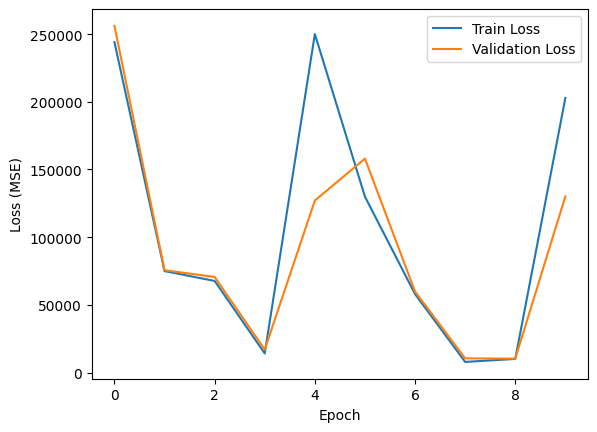

In [15]:
#[Problem 4] Create a model of House Prices

import matplotlib.pyplot as plt
dataset_path = "train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"].values
X = df[["GrLivArea", "YearBuilt"]].values

y = np.log(y).astype(np.float32)[:, np.newaxis]
X = X.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    def __init__(self, X, y, batch_size=10, seed=0):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.seed = seed
        self._reshuffle()

    def _reshuffle(self):
        np.random.seed(self.seed)
        idx = np.random.permutation(len(self.X))
        self.X = self.X[idx]
        self.y = self.y[idx]
        self._stop = int(np.ceil(len(self.X) / self.batch_size))

    def __len__(self):
        return self._stop

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        start = self._counter * self.batch_size
        end = start + self.batch_size
        self._counter += 1
        return self.X[start:end], self.y[start:end]

learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = 1

X_ph = tf.compat.v1.placeholder(tf.float32, [None, n_input])
Y_ph = tf.compat.v1.placeholder(tf.float32, [None, n_classes])

def example_net(x):
    weights = {
        'w1': tf.Variable(tf.random.normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random.normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random.normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random.normal([n_hidden1])),
        'b2': tf.Variable(tf.random.normal([n_hidden2])),
        'b3': tf.Variable(tf.random.normal([n_classes]))
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']))
    output = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    return output

logits = example_net(X_ph)

loss_op = tf.reduce_mean(tf.square(Y_ph - logits))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size, seed=epoch)
        for mini_batch_x, mini_batch_y in get_mini_batch_train:
            sess.run(train_op, feed_dict={X_ph: mini_batch_x, Y_ph: mini_batch_y})

        train_loss = sess.run(loss_op, feed_dict={X_ph: X_train, Y_ph: y_train})
        val_loss = sess.run(loss_op, feed_dict={X_ph: X_val, Y_ph: y_val})
        loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}, loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    test_loss = sess.run(loss_op, feed_dict={X_ph: X_test, Y_ph: y_test})
    print(f"Test MSE: {test_loss:.4f}")

    plt.plot(loss_list, label="Train Loss")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.show()


In [16]:
#[Problem 5] Create a model of MNIST

from keras.datasets import mnist


(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255.0

y_train = y_train.astype(int)[:, np.newaxis]
y_test = y_test.astype(int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train)
y_test_one_hot = enc.transform(y_test)

X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=0
)

class GetMiniBatch:
    def __init__(self, X, y, batch_size=10, seed=0):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.seed = seed
        self._reshuffle()

    def _reshuffle(self):
        np.random.seed(self.seed)
        idx = np.random.permutation(len(self.X))
        self.X = self.X[idx]
        self.y = self.y[idx]
        self._stop = int(np.ceil(len(self.X) / self.batch_size))

    def __len__(self):
        return self._stop

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        start = self._counter * self.batch_size
        end = start + self.batch_size
        self._counter += 1
        return self.X[start:end], self.y[start:end]

learning_rate = 0.01
batch_size = 64
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = 10

X_ph = tf.compat.v1.placeholder(tf.float32, [None, n_input])
Y_ph = tf.compat.v1.placeholder(tf.float32, [None, n_classes])


def example_net(x):
    weights = {
        'w1': tf.Variable(tf.random.normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random.normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random.normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random.normal([n_hidden1])),
        'b2': tf.Variable(tf.random.normal([n_hidden2])),
        'b3': tf.Variable(tf.random.normal([n_classes]))
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']))
    output = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    return output

logits = example_net(X_ph)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_ph, logits=logits))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y_ph, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size, seed=epoch)
        total_loss = 0
        total_acc = 0
        for mini_batch_x, mini_batch_y in get_mini_batch_train:
            sess.run(train_op, feed_dict={X_ph: mini_batch_x, Y_ph: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X_ph: mini_batch_x, Y_ph: mini_batch_y})
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(get_mini_batch_train)
        avg_acc = total_acc / len(get_mini_batch_train)

        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X_ph: X_val, Y_ph: y_val_one_hot})

        print(f"Epoch {epoch+1}, loss: {avg_loss:.4f}, val_loss: {val_loss:.4f}, acc: {avg_acc:.3f}, val_acc: {val_acc:.3f}")

    test_acc = sess.run(accuracy, feed_dict={X_ph: X_test, Y_ph: y_test_one_hot})
    print(f"Test Accuracy: {test_acc:.3f}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1, loss: 9.9674, val_loss: 2.7235, acc: 0.777, val_acc: 0.829
Epoch 2, loss: 1.5921, val_loss: 1.4556, acc: 0.851, val_acc: 0.825
Epoch 3, loss: 0.8038, val_loss: 0.9108, acc: 0.870, val_acc: 0.858
Epoch 4, loss: 0.5402, val_loss: 0.6490, acc: 0.887, val_acc: 0.878
Epoch 5, loss: 0.4445, val_loss: 0.6776, acc: 0.903, val_acc: 0.875
Epoch 6, loss: 0.3665, val_loss: 0.4962, acc: 0.913, val_acc: 0.896
Epoch 7, loss: 0.3289, val_loss: 0.5019, acc: 0.919, val_acc: 0.896
Epoch 8, loss: 0.2777, val_loss: 0.4151, acc: 0.927, val_acc: 0.909
Epoch 9, loss: 0.2469, val_loss: 0.3626, acc: 0.935, val_acc: 0.914
Epoch 10, loss: 0.2170, val_loss: 0.2922, acc: 0.940, val_acc: 0.930
Test Accuracy: 0.926
